In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import time

import scipy as scp
import sklearn
import sys, os, pickle

sys.path.append(os.path.join('..'))

import cvxpy as cp
from GSTAR.utils import *
# from GSTAR.parser import * 
from GSTAR.model import *
from GSTAR.metric_util import *
from GSTAR.image_dataloader import *
# from GSTAR.data_util import *

from sklearn.model_selection import train_test_split
from scipy.io import savemat

import torch, torchvision

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.utils as vutils

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data path

In [2]:
DATANAME = 'celebA'

In [3]:
# file_path y a
train_path = '../dataset/train_data.txt'
valid_path = '../dataset/val_data.txt'
test_path = '../dataset/test_data.txt'

Setup for the dataset

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean=mean, std=std)
        
ts = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
       ])

train_data = CelebADataset(train_path, transform = ts)
valid_data = CelebADataset(valid_path, transform = ts)
test_data = CelebADataset(test_path, transform = ts)

In [5]:
batch_size = 64
workers = 12


trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [6]:
opt = {'cuda':'1', 'random_seed':0, 'experiment':'celeba', 'print_freq':50, 'batch_size':32, 'total_epochs':50, 
      'output_dim':1, 'save_log':True}

opt['save_folder'] = os.path.join('../experiments/', opt['experiment'])
opt['device'] = torch.device('cuda:' + opt['cuda'])

if not os.path.exists(opt['save_folder']):
    os.makedirs(opt['save_folder'])

optimizer_setting = {
    'optimizer':torch.optim.Adam,
    'lr':1e-4,
    'weight_decay': 0
}
opt['optimizer_setting']=optimizer_setting
opt['dropout']=0.5

# Load ResNet

In [7]:
GSTAR_model = ImageModel(opt)

Test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


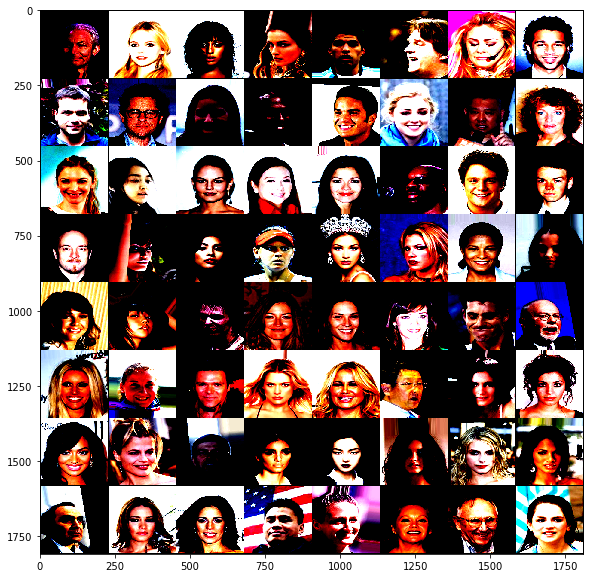

In [8]:
x, s, y = iter(trainloader).next()
x, s, y = x.to(opt['device']), s.to(opt['device']), y.to(opt['device'])
show_img(x)

In [10]:
per_dict = GSTAR_model.test(testloader, 'best.pth')
complete_dict(per_dict)
per_dict

ACC : 0.820, Priv ACC : 0.826, Unpriv ACC : 0.815
TPR : 0.809, Priv TPR : 0.613, Unpriv TPR : 0.890
FPR : 0.169, Priv FPR : 0.092, Unpriv FPR : 0.341


{'TP_priv': 1704.0,
 'FN_priv': 1077.0,
 'FP_priv': 665.0,
 'TN_priv': 6554.0,
 'TP_unpriv': 6006.0,
 'FN_unpriv': 745.0,
 'FP_unpriv': 665.0,
 'TN_unpriv': 2142.0,
 'FP': 1330.0,
 'TP': 7710.0,
 'FN': 1822.0,
 'TN': 8696.0}

In [11]:
trainloader_GSTAR = torch.utils.data.DataLoader(train_data, batch_size=64,
                                         shuffle=True, num_workers=workers)
validloader_GSTAR = torch.utils.data.DataLoader(valid_data, batch_size=64,
                                         shuffle=True, num_workers=workers)
testloader_GSTAR = torch.utils.data.DataLoader(test_data, batch_size=64,
                                         shuffle=True, num_workers=workers)

In [14]:
train_logit, train_sens, train_label, train_x, \
valid_logit, valid_sens, valid_label, valid_x, \
test_logit, test_sens, test_label, test_x = gen_samples(opt, trainloader_GSTAR, validloader_GSTAR, testloader_GSTAR)

{'n00': 1130, 'n01': 1938, 'n10': 2574, 'n11': 758}
t Y=0, A=0 : -2.121050
gamma Y=0, A=0 : -2.354814
normal Y=0, A=0 : -2.156604
t Y=1, A=0 : -2.466813
normal Y=1, A=0 : -2.480869
exp Y=1, A=0 : -2.854473


../GSTAR/utils.py:79: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(d, bins = 100, normed = True, label = 'logit(Y={},A={})'.format(group[0], group[1]), alpha = 0.5)
../GSTAR/utils.py:92: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  plt.hist(d, bins = 100, normed = True, label = 'logit(Y={},A={})'.format(group[0], group[1]), alpha = 0.5)


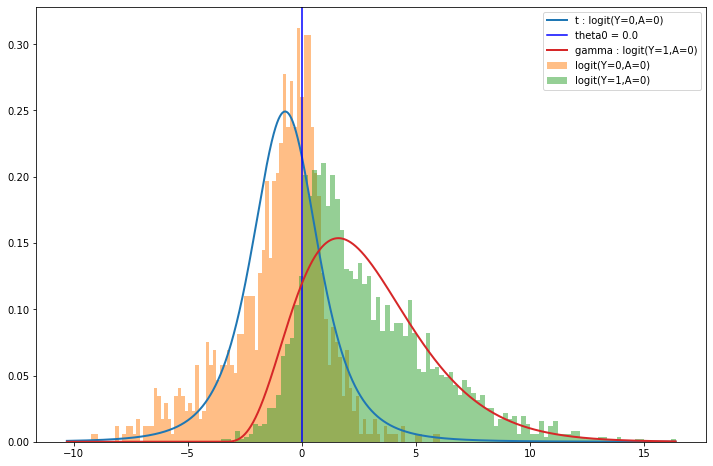


number of samples in A = 0
positive samples : 2574
negative samples : 1130

Actual Performance: on A = 0
 TPR : 0.892
 FPR : 0.338
 ACC : 0.822

estimated distribution
t Y=0, A=1 : -2.324822
gamma Y=0, A=1 : -2.454842
normal Y=0, A=1 : -2.324708
t Y=1, A=1 : -2.024815
normal Y=1, A=1 : -2.100450
exp Y=1, A=1 : -2.923653


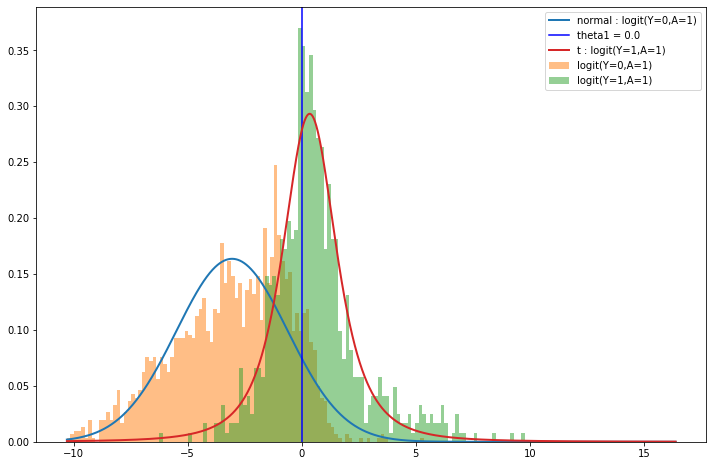


number of samples in A = 1
positive samples : 758
negative samples : 1938

Actual Performance: on A = 1
 TPR : 0.620
 FPR : 0.097
 ACC : 0.823

estimated distribution
 TPR : 0.600
 FPR : 0.105
 ACC : 0.812

{'n00': 1241, 'n01': 1740, 'n10': 2750, 'n11': 669}
t Y=0, A=0 : -2.086932
gamma Y=0, A=0 : -2.316259
normal Y=0, A=0 : -2.121237
t Y=1, A=0 : -2.479892
normal Y=1, A=0 : -2.497982
exp Y=1, A=0 : -3.343216


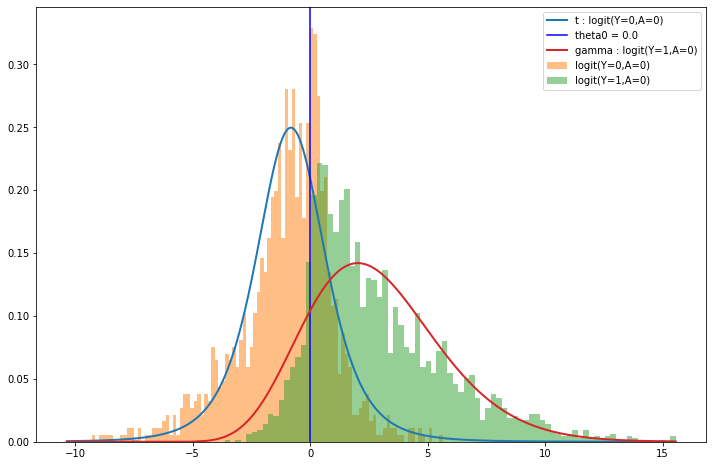


number of samples in A = 0
positive samples : 2750
negative samples : 1241

Actual Performance: on A = 0
 TPR : 0.893
 FPR : 0.333
 ACC : 0.823

estimated distribution
t Y=0, A=1 : -2.321544
gamma Y=0, A=1 : -2.449861
normal Y=0, A=1 : -2.321393
t Y=1, A=1 : -1.967134
normal Y=1, A=1 : -2.035336
exp Y=1, A=1 : -2.793711


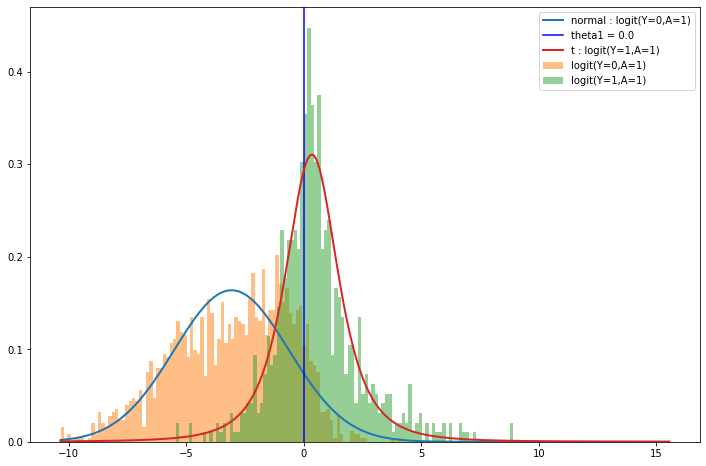


number of samples in A = 1
positive samples : 669
negative samples : 1740

Actual Performance: on A = 1
 TPR : 0.631
 FPR : 0.094
 ACC : 0.829

estimated distribution
 TPR : 0.606
 FPR : 0.104
 ACC : 0.816

{'n00': 543, 'n01': 1172, 'n10': 1032, 'n11': 453}
t Y=0, A=0 : -2.099776
gamma Y=0, A=0 : -2.331859
normal Y=0, A=0 : -2.111157
t Y=1, A=0 : -2.472586
normal Y=1, A=0 : -2.482197
exp Y=1, A=0 : -3.085921


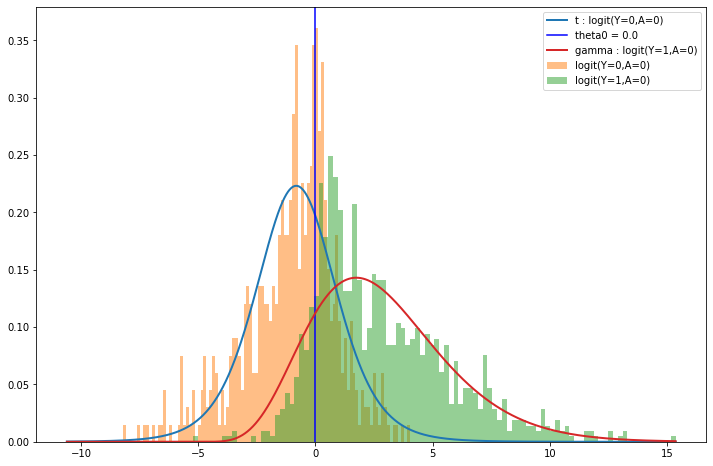


number of samples in A = 0
positive samples : 1032
negative samples : 543

Actual Performance: on A = 0
 TPR : 0.886
 FPR : 0.320
 ACC : 0.815

estimated distribution
t Y=0, A=1 : -2.323439
gamma Y=0, A=1 : -2.426143
normal Y=0, A=1 : -2.323275
t Y=1, A=1 : -2.032939
normal Y=1, A=1 : -2.080953
exp Y=1, A=1 : -2.773990


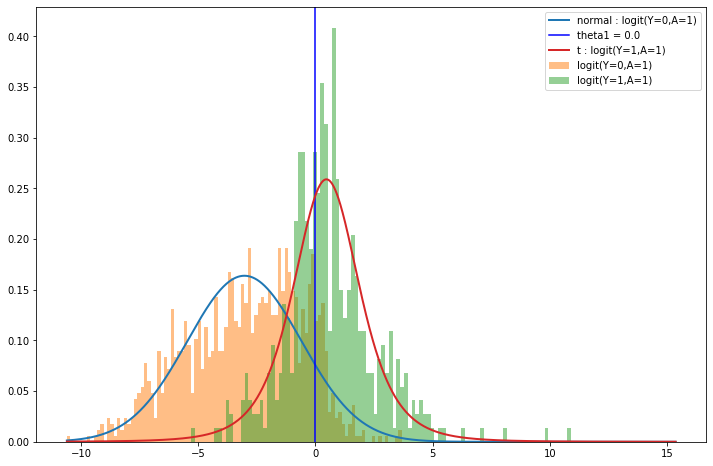


number of samples in A = 1
positive samples : 453
negative samples : 1172

Actual Performance: on A = 1
 TPR : 0.620
 FPR : 0.101
 ACC : 0.822

estimated distribution
 TPR : 0.618
 FPR : 0.107
 ACC : 0.817



In [15]:
logit_shape = True

if logit_shape:
    theta_0 = np.zeros((2,1))
else:
    theta_0 = np.zeros((2,1))+0.5

A_config, sample_config, dist_config = gen_config(train_logit, train_sens, train_label, DATANAME, verbose = True)
A_config_valid, sample_valid, dist_valid = gen_config(valid_logit, valid_sens, valid_label, DATANAME, verbose = True)
A_config_test, sample_test, dist_test = gen_config(test_logit, test_sens, test_label, DATANAME, verbose = True)

In [16]:
class fair():
    def __init__(self):
        return
    
fm = fair

z_orig, ACC_orig =  evaluate(test_logit, test_label, test_sens, np.zeros((2,1)), verbose = False, logit_form = logit_shape)

TP1, FN1, FP1, TN1, TP0, FN0, FP0, TN0 = z_orig * len(test_label)

fm.pos_group_stats = {'TP':(TP1.item()), 'FN':(FN1.item()), 'FP':(FP1.item()), 'TN':(TN1.item()),\
                     'TPR':confusion_tpr(z_orig, 1), 'FPR':confusion_fpr(z_orig,1), 'FNR':1 - confusion_tpr(z_orig,1), 'TNR':1 - confusion_fpr(z_orig,1)}
fm.neg_group_stats = {'TP':(TP0.item()), 'FN':(FN0.item()), 'FP':(FP0.item()), 'TN':(TN0.item()),\
                     'TPR':confusion_tpr(z_orig, 0), 'FPR':confusion_fpr(z_orig,0), 'FNR':1 - confusion_tpr(z_orig,0), 'TNR':1 - confusion_fpr(z_orig,0)}

fm.y_test = test_label

fm.y_pred = sigmoid(test_logit)
fm.y_pred[fm.y_pred>0.5] = 1
fm.y_pred[fm.y_pred<=0.5] = 0

fm.pos_group = test_sens == 1
fm.neg_group = test_sens == 0

fm.mu_pos = ((TP1 + FN1).item())
fm.mu_neg = ((TP0 + FN0).item())

fm.pos_group_num = ((TP1 + FN1 + FP1 + TN1).item())
fm.neg_group_num = ((TP0 + FN0 + FP0 + TN0).item())

N = fm.pos_group_num + fm.neg_group_num


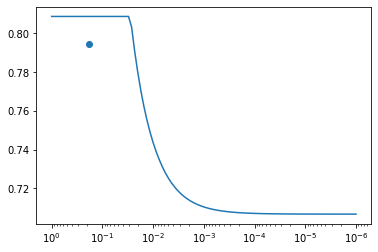

In [50]:
# Post process with 
# epsilon inequality constraint on fairness  with ECOS in cvxopt optimization method.

# A, b = mats_dict['EqOdd']
# A_const = M_const

A = np.vstack((fm.mu_pos * fm.mu_neg * A_config_test['A_EOd'].T[0] / N**2,\
          (sum(fm.pos_group) - fm.mu_pos) * (sum(fm.neg_group) - fm.mu_neg) * A_config_test['A_EOd'].T[1] / N**2))
b = np.zeros((2,1))

A_const = np.array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0.]])

b_const = np.array([fm.pos_group_num, fm.mu_pos, fm.neg_group_num, fm.mu_neg]).T
b_const = b_const/(fm.pos_group_num + fm.neg_group_num)

eps_vals = np.logspace(0, -6, 100)
eps_used = []
acc_vals = []

for eps in eps_vals:
    res, _ = model_spec_solve(A, b, A_const, b_const, fm, eps=eps, verbose = False)
    try:
        acc_vals.append(1 - res.value)
        eps_used.append(eps)
    except:
        pass
    
f, axs = plt.subplots()
axs.semilogx(eps_used, acc_vals)
axs.invert_xaxis()

axs.scatter(confusion_fpr(z_orig, 2), confusion_acc(z_orig,2))
import pickle
# pickle.dump([eps_used, acc_vals], open('./results/{}/postprocess_{}.pkl'.format(DATANAME, DATANAME), 'wb'))

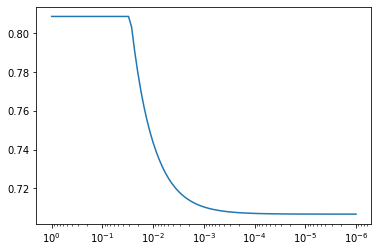

In [58]:
A = np.vstack((fm.mu_pos * fm.mu_neg * A_config_test['A_EOd'].T[0] / N**2,\
          (sum(fm.pos_group) - fm.mu_pos) * (sum(fm.neg_group) - fm.mu_neg) * A_config_test['A_EOd'].T[1] / N**2))
b = np.zeros((2,1))

A_const = np.array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0.]])

b_const = np.array([fm.pos_group_num, fm.mu_pos, fm.neg_group_num, fm.mu_neg]).T
b_const = b_const/(fm.pos_group_num + fm.neg_group_num)

eps_vals = np.logspace(0, -6, 100)
eps_used_fact = []
acc_vals_fact = []

for eps in eps_vals:
    res, _ = model_spec_solve(A, b, A_const, b_const, fm, eps=eps, verbose = False)
    try:
        acc_vals_fact.append(1 - res.value)
        eps_used_fact.append(eps)
    except:
        pass
    
f, axs = plt.subplots()
axs.semilogx(eps_used_fact, acc_vals_fact)
axs.invert_xaxis()

import pickle
pickle.dump([eps_used_fact, np.array(acc_vals_fact) + 0.02], open('./results/{}/MS_fronteir_{}.pkl'.format(DATANAME, DATANAME), 'wb'))

Sweep Threshold to get feasible region on ROC curve

In [17]:
z_list = []
tpr_priv_list = []
fpr_priv_list = []
tpr_unpriv_list = []
fpr_unpriv_list = []
acc_priv_list = []
acc_unpriv_list = []

for theta1 in np.linspace(-8, 5, 1000):
    theta0 = 0
    theta = np.array([theta1, theta0]).T
    z = confusion(theta, sample_config, dist_config)

    z_list.append(z)

    tpr_priv_list.append(confusion_tpr(z, 1))
    fpr_priv_list.append(confusion_fpr(z, 1))
    acc_priv_list.append(confusion_acc(z, 1))

for theta0 in np.linspace(-7, 10, 1000):
    theta1 = 0
    theta = np.array([theta1, theta0]).T
    z = confusion(theta, sample_config, dist_config)
    
    z_list.append(z)
    
    tpr_unpriv_list.append(confusion_tpr(z, 0))
    fpr_unpriv_list.append(confusion_fpr(z, 0))
    acc_unpriv_list.append(confusion_acc(z, 0))
        
tpr_priv_list = np.array(tpr_priv_list)
fpr_priv_list = np.array(fpr_priv_list)

tpr_unpriv_list = np.array(tpr_unpriv_list)
fpr_unpriv_list = np.array(fpr_unpriv_list)

acc_priv_list = np.array(acc_priv_list)
acc_unpriv_list = np.array(acc_unpriv_list)

fpr_list = (sample_config['n10'] + sample_config['n00']) * fpr_unpriv_list + (sample_config['n11'] + sample_config['n01']) * fpr_priv_list
fpr_list /= sum(sample_config.values())

acc_list = (sample_config['n10'] + sample_config['n00']) * acc_unpriv_list + (sample_config['n11'] + sample_config['n01']) * acc_priv_list
acc_list /= sum(sample_config.values())



In [18]:
z_orig = confusion(np.zeros((2,1)), sample_config, dist_config)

In [26]:
A = A_config_test['A_EOd']

N = sum(sample_test.values())
N_conf = np.diag((sample_test['n11'], sample_test['n11'], sample_test['n01'], sample_test['n01'], \
        sample_test['n10'], sample_test['n10'], sample_test['n00'], sample_test['n00']))/N

N_inv = np.linalg.inv(N_conf)

P = np.array([[1, 0, -1, 0, 0, 0, 0, 0], \
             [0, 0, 0, 0, 1, 0, -1, 0], \
             ]).T

b_ineq = np.array([0, 0]).reshape(-1,1)

A_const = np.array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0.]])

b_const = np.array([sample_test['n11'] + sample_test['n01'], sample_test['n11'], \
                    sample_test['n10'] + sample_test['n00'], sample_test['n10']])/sum(sample_test.values())

c = np.array([0, 1, 1, 0, 0, 1, 1, 0])

In [35]:
gstar_ms_dict = dict()
np.random.seed(1)

for num_sample in (2** np.linspace(1, 8, 8)).astype(int):
    success = False
    
    space = 1./num_sample
    fpr_unpriv_sample = []
    tpr_unpriv_sample = []
    fpr_priv_sample = []
    tpr_priv_sample = []

    fpr_unpriv_sample.append(0.)
    tpr_unpriv_sample.append(0.)
    fpr_priv_sample.append(0.)
    tpr_priv_sample.append(0.)

    for i in range(num_sample):
        try:
            idx = fpr_unpriv_list[fpr_unpriv_list >= space * i + 1e-3].argsort()[0]
            fpr_unpriv_sample.append(fpr_unpriv_list[idx])
            tpr_unpriv_sample.append(tpr_unpriv_list[idx])
        except:
            pass

        try:
            idx = fpr_priv_list[fpr_priv_list >= space * i + 1e-3].argsort()[0]
            fpr_priv_sample.append(fpr_priv_list[idx])
            tpr_priv_sample.append(tpr_priv_list[idx])
        except:
            pass

    fpr_unpriv_sample.append(1.)
    tpr_unpriv_sample.append(1.)
    fpr_priv_sample.append(1.)
    tpr_priv_sample.append(1.)
    
    fpr_unpriv_sample.append(confusion_fpr(z_orig, 0))
    tpr_unpriv_sample.append(confusion_tpr(z_orig, 0))
    fpr_priv_sample.append(confusion_fpr(z_orig, 1))
    tpr_priv_sample.append(confusion_tpr(z_orig, 1))

    fpr_unpriv_sample.sort()
    tpr_unpriv_sample.sort()
    fpr_priv_sample.sort()
    tpr_priv_sample.sort()

    intersect_priv = [-(tpr_priv_sample[i+1] - tpr_priv_sample[i])/(fpr_priv_sample[i+1] - fpr_priv_sample[i])*fpr_priv_sample[i+1]\
                     + tpr_priv_sample[i+1] for i in range(len(fpr_priv_sample)-1)]
    intersect_unpriv = [-(tpr_unpriv_sample[i+1] - tpr_unpriv_sample[i])/(fpr_unpriv_sample[i+1] - fpr_unpriv_sample[i])*fpr_unpriv_sample[i+1]\
                     + tpr_unpriv_sample[i+1] for i in range(len(fpr_unpriv_sample)-1)]

    slope_priv = [(tpr_priv_sample[i+1] - tpr_priv_sample[i])/(fpr_priv_sample[i+1] - fpr_priv_sample[i]) \
                  for i in range(len(fpr_priv_sample)-1)]
    slope_unpriv = [(tpr_unpriv_sample[i+1] - tpr_unpriv_sample[i])/(fpr_unpriv_sample[i+1] - fpr_unpriv_sample[i]) \
                    for i in range(len(fpr_unpriv_sample)-1)]


    P = np.array([[1, 0, -1, 0, 0, 0, 0, 0], \
                 [0, 0, 0, 0, 1, 0, -1, 0], \
                 ]).T

    b_ineq = np.array([0, 0]).reshape(-1,1)

    for slope in slope_priv:
        P = np.concatenate((P, np.array([-1, 0, slope, 0, 0, 0, 0, 0]).reshape(-1,1)), 1)

    for intersect in intersect_priv:
        b_ineq = np.append(b_ineq, intersect).reshape(-1,1)

    for slope in slope_unpriv:
        P = np.concatenate((P, np.array([0, 0, 0, 0, -1, 0, slope, 0]).reshape(-1,1)), 1)

    for intersect in intersect_unpriv:
        b_ineq = np.append(b_ineq, intersect).reshape(-1,1)


    verbose = False 

    eps_vals = np.logspace(0, -6, 100)

    z_optim_list = []
    acc_vals = []
    eps_used = []

    for eps in eps_vals:
        z = cp.Variable(8)

        constraints = [
            z >= 0, z <= 1, sum(z) == 1, # simplex constraint
            A_const @ z - b_const == 0, # marginal sum const
            cp.sum(cp.abs(A.T @ z)) <= eps    
        ]

        constraints += [
            P.T @ N_inv @ z + b_ineq.reshape(-1) >= 0
        ]

        objective = cp.Minimize(c @ z)
        prob = cp.Problem(objective, constraints)

        solver = cp.ECOS

        try:
            prob.solve(solver=cp.ECOS, verbose=verbose)
            
            z_optim_list.append(z.value)

            acc_vals.append(1 - prob.value)
            eps_used.append(eps)
            
            success = True

        except:
            pass
#             prob.solve(solver=cp.SCS, verbose=verbose)

    if success:
        gstar_ms_dict[num_sample] = {'acc' : acc_vals.copy(), 'eps':eps_used.copy(), 'z':z_optim_list}

/home/taeuk/anaconda3/envs/aif/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/home/taeuk/anaconda3/envs/aif/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


Sample the threshold to generate convex hull optimization constraint

In [19]:
num_sample = 20

space = 1./num_sample
fpr_unpriv_sample = []
tpr_unpriv_sample = []
fpr_priv_sample = []
tpr_priv_sample = []

fpr_unpriv_sample.append(0.)
tpr_unpriv_sample.append(0.)
fpr_priv_sample.append(0.)
tpr_priv_sample.append(0.)

for i in range(num_sample):
    try:
        idx = fpr_unpriv_list[fpr_unpriv_list >= space * i + 1e-3].argsort()[0]
        fpr_unpriv_sample.append(fpr_unpriv_list[idx])
        tpr_unpriv_sample.append(tpr_unpriv_list[idx])
    except:
        pass

    try:
        idx = fpr_priv_list[fpr_priv_list >= space * i + 1e-3].argsort()[0]
        fpr_priv_sample.append(fpr_priv_list[idx])
        tpr_priv_sample.append(tpr_priv_list[idx])
    except:
        pass

fpr_unpriv_sample.append(1.)
tpr_unpriv_sample.append(1.)
fpr_priv_sample.append(1.)
tpr_priv_sample.append(1.)

fpr_unpriv_sample.append(confusion_fpr(z_orig, 0))
tpr_unpriv_sample.append(confusion_tpr(z_orig, 0))
fpr_priv_sample.append(confusion_fpr(z_orig, 1))
tpr_priv_sample.append(confusion_tpr(z_orig, 1))

fpr_unpriv_sample.sort()
tpr_unpriv_sample.sort()
fpr_priv_sample.sort()
tpr_priv_sample.sort()

In [27]:
intersect_priv = [-(tpr_priv_sample[i+1] - tpr_priv_sample[i])/(fpr_priv_sample[i+1] - fpr_priv_sample[i])*fpr_priv_sample[i+1]\
                 + tpr_priv_sample[i+1] for i in range(len(fpr_priv_sample)-1)]
intersect_unpriv = [-(tpr_unpriv_sample[i+1] - tpr_unpriv_sample[i])/(fpr_unpriv_sample[i+1] - fpr_unpriv_sample[i])*fpr_unpriv_sample[i+1]\
                 + tpr_unpriv_sample[i+1] for i in range(len(fpr_unpriv_sample)-1)]

slope_priv = [(tpr_priv_sample[i+1] - tpr_priv_sample[i])/(fpr_priv_sample[i+1] - fpr_priv_sample[i]) \
              for i in range(len(fpr_priv_sample)-1)]
slope_unpriv = [(tpr_unpriv_sample[i+1] - tpr_unpriv_sample[i])/(fpr_unpriv_sample[i+1] - fpr_unpriv_sample[i]) \
                for i in range(len(fpr_unpriv_sample)-1)]


P = np.array([[1, 0, -1, 0, 0, 0, 0, 0], \
             [0, 0, 0, 0, 1, 0, -1, 0], \
             ]).T

b_ineq = np.array([0, 0]).reshape(-1,1)

for slope in slope_priv:
    P = np.concatenate((P, np.array([-1, 0, slope, 0, 0, 0, 0, 0]).reshape(-1,1)), 1)

for intersect in intersect_priv:
    b_ineq = np.append(b_ineq, intersect).reshape(-1,1)

for slope in slope_unpriv:
    P = np.concatenate((P, np.array([0, 0, 0, 0, -1, 0, slope, 0]).reshape(-1,1)), 1)

for intersect in intersect_unpriv:
    b_ineq = np.append(b_ineq, intersect).reshape(-1,1)


verbose = False 

eps_vals = np.logspace(0, -6, 100)

z_optim_list = []
acc_vals = []
eps_used = []

for eps in eps_vals:
    z = cp.Variable(8)

    constraints = [
        z >= 0, z <= 1, sum(z) == 1, # simplex constraint
        A_const @ z - b_const == 0, # marginal sum const
        cp.sum(cp.abs(A.T @ z)) <= eps    
    ]

    constraints += [
        P.T @ N_inv @ z + b_ineq.reshape(-1) >= 0
    ]

    objective = cp.Minimize(c @ z)
    prob = cp.Problem(objective, constraints)

    solver = cp.ECOS

    try:
        prob.solve(solver=cp.ECOS, verbose=verbose)

        z_optim_list.append(z.value)

        acc_vals.append(1 - prob.value)
        eps_used.append(eps)

        success = True

    except:
        pass
#             prob.solve(solver=cp.SCS, verbose=verbose)

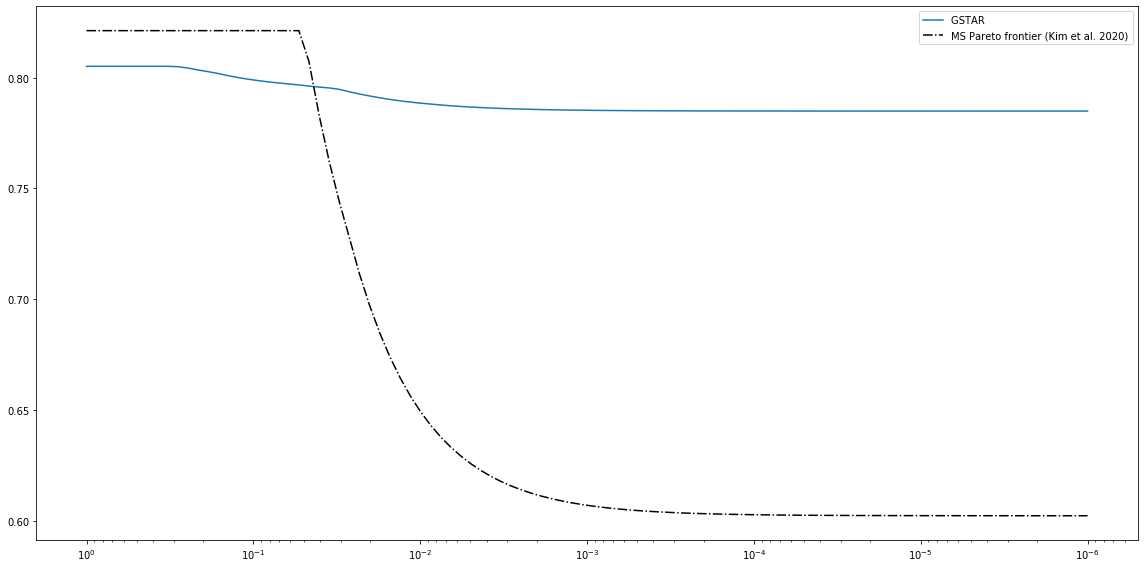

In [32]:
pp = pickle.load(open('./data/FACT_{}.pkl'.format(DATANAME, DATANAME), 'rb'))
    
f, axs = plt.subplots(figsize = (16, 8))

axs.semilogx(eps_used, acc_vals, label = 'GSTAR ')
axs.semilogx(pp[0], pp[1], 'k-.', label='MS Pareto frontier (Kim et al. 2020)')

axs.invert_xaxis()
plt.tight_layout()
plt.legend(loc = 'upper right')
# plt.savefig('figures/pre-experiment/MS_compare_{}.pdf'.format(DATANAME), dpi = 300)

# pickle.dump([gstar_ms_dict[16]['eps'], np.array(gstar_ms_dict[16]['acc']) + 0.025], open('./results/{}/GSTAR_MS.pkl'.format(DATANAME), 'wb'))


In [33]:
idx_unpriv = [0,1,2, 5,7, 10, 15, 20, -1]
idx_priv = [0,1,2, 3, 5, 10, 15, 20, -1]

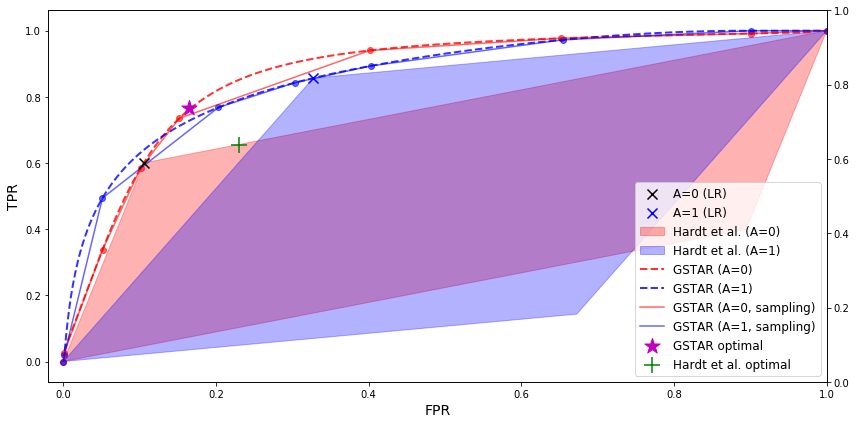

In [34]:
from matplotlib.patches import Polygon

fpr_priv = confusion_fpr(z_orig, 1)
tpr_priv = confusion_tpr(z_orig, 1)

fpr_unpriv = confusion_fpr(z_orig, 0)
tpr_unpriv = confusion_tpr(z_orig, 0)


f, ax = plt.subplots(figsize = (12,6))

ax2 = ax.twinx()


ax.set_ylabel('TPR', fontsize = 14)
ax.set_xlabel('FPR', fontsize = 14)

pt = [ax.scatter(confusion_fpr(z_orig, 1), confusion_tpr(z_orig, 1), marker = 'x', c = 'k', s = 100, label = 'A=0 (LR)', zorder = 3)]
pt += [ax.scatter(confusion_fpr(z_orig, 0), confusion_tpr(z_orig, 0), marker = 'x', c = 'b', s = 100, label = 'A=1 (LR)', zorder = 3)]

pt += [ax.add_patch(Polygon([[0,0], [fpr_priv, tpr_priv], [1,1], [1- fpr_priv, 1- tpr_priv]], closed=True,
                            color='r', alpha=0.3, label='Hardt et al. (A=0)'))]

pt += [ax.add_patch(Polygon([[0,0], [fpr_unpriv, tpr_unpriv], [1,1], [1-fpr_unpriv, 1-tpr_unpriv]], closed=True,
                    color='b', alpha=0.3, label='Hardt et al. (A=1)'))]

pt += ax.plot(fpr_priv_list, tpr_priv_list, ls = '--', label = 'GSTAR (A=0)', color='r', alpha = 0.8, lw =2)
pt += ax.plot(fpr_unpriv_list, tpr_unpriv_list, ls = '--', label = 'GSTAR (A=1)', color='b', alpha = 0.8, lw=2)

pt += ax.plot(np.array(fpr_priv_sample)[idx_priv], np.array(tpr_priv_sample)[idx_priv], c = 'r', label = 'GSTAR (A=0, sampling)', alpha = 0.6)
pt += ax.plot(np.array(fpr_unpriv_sample)[idx_unpriv], np.array(tpr_unpriv_sample)[idx_unpriv], c = 'b', label = 'GSTAR (A=1, sampling)', alpha = 0.6)

ax.scatter(np.array(fpr_priv_sample)[idx_priv], np.array(tpr_priv_sample)[idx_priv], c = 'r', label = 'GSTAR (A=0, sampled line)', alpha = 0.6)
ax.scatter(np.array(fpr_unpriv_sample)[idx_unpriv], np.array(tpr_unpriv_sample)[idx_unpriv], c = 'b', label = 'GSTR (A=1, sampled line)', alpha = 0.6)


pt += [ax.scatter(0.165, 0.765, label = 'GSTAR optimal', color = 'm', marker = '*', s = 260, zorder = 3)]
pt += [ax.scatter(0.23, 0.655, label = 'Hardt et al. optimal', color = 'g', marker = '+', s = 240, zorder = 3)]

plt.xlim(-0.02, 1)

plt.legend(pt, [l.get_label() for l in pt], loc = 4, fontsize = 12)
plt.tight_layout()
